# NYC Taxi Fare Prediction
Author: Arthur Dimitri

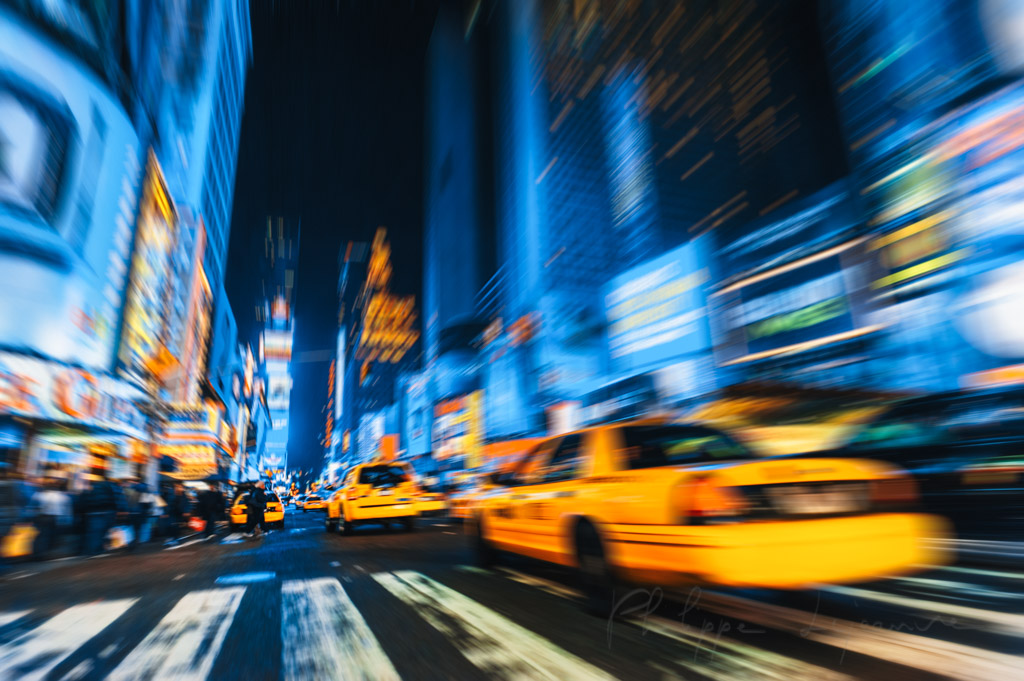

# Introduction

New York is one of the most famous cities in the world. One of its districts, Manhattan, has a high demographic density and concentrates the main shopping centres. Going from one point of the city to another might take some time and cost a bit. Wouldn't it be useful to predict the price using AI?

# Dataset Description

## File Descriptions

* train.csv - Input features and target fare_amount values for the training set (about 55M rows).
* test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
* sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

## Training Set

The data set has 55M rows and some features. They are: 

* key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.
* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.
* fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

# 1. Reading Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import time
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [ ]:
train =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 3_000_000)
test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
train.head()

## 1.1 Statistically Describing Data

In [ ]:
train.describe()

# 2. Basic Feature Generation

Before we move on to an exploratory data analysis, we first need some features. Let's extract them from the dataset.

## 2.1 Haversine Distance Between Locations

According to Wikipedia, "*The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes*". Let's apply that to our dataset. 

In [ ]:
def haversine(lon1_array, lat1_array, lon2_array, lat2_array):
    
    distances = []
    
    for pos in range(len(lon1_array)):
        lon1, lat1, lon2, lat2 = map(radians, [lon1_array[pos], lat1_array[pos], lon2_array[pos], lat2_array[pos]])
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))*6371
        distances.append(c)
    return distances

train['dist_km'] = haversine(train['pickup_longitude'].to_numpy(),train['pickup_latitude'].to_numpy(),train['dropoff_longitude'].to_numpy(),train['dropoff_latitude'].to_numpy())
test['dist_km'] = haversine(test['pickup_longitude'].to_numpy(),test['pickup_latitude'].to_numpy(),test['dropoff_longitude'].to_numpy(),test['dropoff_latitude'].to_numpy())
train.head(5)

## 2.2 Converting Timestamps

In [ ]:
train['key'] = pd.to_datetime(train['key'], errors='coerce')
test['key'] = pd.to_datetime(test['key'], errors='coerce')
train = train.assign(hour = train.key.dt.hour, month = train.key.dt.month, year = train.key.dt.year, weekday = train.key.dt.weekday)
test = test.assign(hour = test.key.dt.hour, month = test.key.dt.month, year = test.key.dt.year, weekday = test.key.dt.weekday)
train

In [ ]:
train.drop(columns=['key','pickup_datetime'],axis=1,inplace=True, errors='ignore')
test.drop(columns=['key','pickup_datetime'],axis=1,inplace=True, errors='ignore')
train

We have sucessfully extracted the features we need for a basic EDA. After that we dropped the original columns that don't help the model.

# 3. Exploratory Data Analysis

The main objective here is to familiarize with the data and investigate some hypothesis. Let's list some of them:
* Are there specific hours during the day that affect the mean fare amount?
* Do airport trips have fixed fare?
* Do overnight trips have an increase in the mean fare amount?
* How many long/short trips do we have in the dataset?
* What is the passenger count distribution?
* What is the fare amount distribution?
* What is the trip distance distribution?
* How do the distance relate to the fare amount?


## 3.1 Hours and Demand

### 3.1.1 Rush Hours

#### 3.1.1.1 Normal Working Days

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Number of Taxi Trips During Normal Working Days')
sns.set_style("white")
sns.countplot(x='hour', data=train.loc[(train.weekday >= 0) & (train.weekday <= 4)],palette='rocket')

As one can see above, there are some periods of the day that we should pay attention to. In the morning, from 7am to 9am we can notice an increase in the number of taxi trips. This might be related to the time where people are getting to work. From 16pm to 20pm we have an increase on the demand. These rush hours should be taken into consideration in the feature engineering process. 

In [ ]:
train.loc[(train.weekday >=0) & (train.weekday <=4)].shape

#### 3.1.1.1.2 Weekends

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Number of Taxi Trips During Weekends')
sns.set_style("white")
sns.countplot(x='hour', data=train.loc[(train.weekday >= 5) & (train.weekday <= 6)],palette='rocket')

In [ ]:
train.loc[(train.weekday >= 5) & (train.weekday <= 6)].shape

On the weekends, the results are a bit different. We have a great part of the trips ocurring from 0am to 2am. These might be related to airport trips, or people taking taxis to/from pubs. From 16pm to 20pm we have an increase on the demand. 

### 3.1.2 Hours and Mean Fare Amount - Working Weekdays vs Weekends

In [ ]:
weekdays = train.loc[(train.weekday >= 0) & (train.weekday <= 5)]
weekends =  train.loc[(train.weekday >= 6) & (train.weekday <= 7)]
weekdays_fare = weekdays.groupby(['hour']).fare_amount.mean().to_frame().reset_index()
weekends_fare = weekends.groupby(['hour']).fare_amount.mean().to_frame().reset_index()

In [ ]:
np.array(weekdays_fare.hour)
np.array(weekends_fare.fare_amount)

In [ ]:
x = np.array(weekdays_fare.hour)
y = np.array(weekdays_fare.fare_amount)
z = np.array(weekends_fare.fare_amount)


plt.figure(figsize=(16,8))
plt.title('Mean Fare Amount During the Day - Working Days vs Weekend')
plt.xlabel('Hours of the day')
plt.ylabel('Mean Fare Amount')
ax = plt.subplot(111)
ax.bar(x-0.2, y, width=0.2, color='black', align='center',label = 'Week Days')
ax.bar(x, z, width=0.2, color='gray', align='center', label = 'Weekend')
plt.xticks(range(0,24))
plt.legend()
plt.show()

On normal working days, from monday to friday, it can be seen that overnight there is an increase in the mean fare amount, from 20pm to aproximately 6am. This can be related to some tax applied due to the hours, and should be investigated in feature engineering. 

## 3.2 Distance Distribution

Let's check an histogram of trip distance in Km.

In [ ]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Distance in Km Distribution')
plt.xlabel('Distance in Km')
plt.xlim(-10,200)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(train[train.dist_km <500 ].dist_km, shade=True)

As can be seen above, most part of the trips vary from aproximately 5Km to 25Km. The least frequent values of distance extend indefinetely even beyond the axis limits we have set. Taking into consideration all the possible trips within and outside NYC, some data cleaning should be made to remove outliers and make the feature 'dist_km' more correlated to the target variable. 

Analyzing the possible trips with google maps, from NYC centre to the most distant possible county, it is about 135km distant. We should remove trips where this limit is exceeded.  

## 3.3 Fare Amount Distribution

In [ ]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount')
plt.xlim(-10,200)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(train[train.fare_amount <500 ].fare_amount, shade=True)

As can be seen, most trips vary from 2.5 dolars to 20 dolars. There are negative values. The distribution extends for very high fare amount values. In the data cleaning, negative values and fare amounts that go beyond a certain limit (close to a hundred dolars) should be taken out of the dataset. 

## 3.4 Relationship Between Distance and Fare Amount 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
idx = (train.dist_km < 7500) & (train.fare_amount < 600)
axs[0].scatter(train[idx].dist_km, train[idx].fare_amount, alpha=0.2)
plt.ylim(0,200)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')


# zoom in on part of data
idx = (train.dist_km < 25) & (train.fare_amount < 300)
axs[1].scatter(train[idx].dist_km, train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance km')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 25 km, fare < $100');

From the right scatterplot it can be seen that, despite some outliers:
1. There's a kind of linear relationship between the distance in kilometers and the fare.
2. There are many points with 0km with a correspondent fare. These could be outliers or trips that begin and end in the same point (a person calls a taxi to do something in the city and gets back home)
2. There are some trips with very high distance and low fare. These are outliers and should be removed from the dataset. 
3. Next to the 60 dolar fare there are some horizontal lines. They migh be related to trips with fixed fare from specific locations, such as airports.
To confirm this hypothesis, let's exclude the rows with the pickup locations refered to the airports:

In [ ]:

JFK={"min_long":-73.81,
    "min_lat":40.63,
    "max_long":-73.77,
    "max_lat":40.67}
LGA = {
    "min_long":-73.89,
    "min_lat":40.76,
    "max_long":-73.85,
    "max_lat":40.79
}

JFK_loc = train.loc[(train.pickup_longitude >= JFK['min_long']) & (train.pickup_longitude <= JFK['max_long']) & (train.pickup_latitude >= JFK['min_lat']) & (train.pickup_latitude <= JFK['max_lat'])]
LGA_loc = train.loc[(train.pickup_longitude >= LGA['min_long']) & (train.pickup_longitude <= LGA['max_long']) & (train.pickup_latitude >= LGA['min_lat']) & (train.pickup_latitude <= LGA['max_lat'])]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
idx = (JFK_loc.dist_km < 60) & (JFK_loc.fare_amount < 80)
line_1 = 0.6*(np.arange(0,50))
axs[0].scatter(JFK_loc[idx].dist_km, JFK_loc[idx].fare_amount, alpha=0.2)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('JFK - Pickup or Dropoff')
axs[0].plot(JFK_loc[idx].dist_km, 1.67*JFK_loc[idx].dist_km,':r',label='y = 1.67*x')
axs[0].legend()


idx = (LGA_loc.dist_km < 60) & (LGA_loc.fare_amount < 80) & (LGA_loc.fare_amount >= 0)
axs[1].scatter(LGA_loc[idx].dist_km, LGA_loc[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance km')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('LGA - Pickup or Dropoff')
axs[1].plot(LGA_loc[idx].dist_km, 1.625*LGA_loc[idx].dist_km,':r',label='y = 1.625*x')
axs[1].legend()

In [ ]:
del JFK_loc 
del LGA_loc

Part of our hypothesis is confirmed. Locations that refer to JFK, from 40 to 60 dolars have a horizontal line, specially in short distace trips and trips between 20 and 30km. Besides it, there's some kind of linear relationship between the distance and the fare amount. There are some outliers beneath the curves. These values could be removed to train a better model.

## 3.5 Distributions of Pickup and Dropoff Points in NYC

In [ ]:
# import street map
street_map = gpd.read_file('../input/ny-map/geo_export_b5f6f452-87a0-46a0-95eb-2b80c4471a56.shp')
# designate coordinate system
crs = {'init':'espc:4326'}

sampled = train.sample(frac=0.008)
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(sampled['pickup_longitude'], sampled['pickup_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(sampled,
 crs = crs,
 geometry = geometry)

In [ ]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')

geo_df.plot(column='fare_amount',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('Pickup Locations and Fare Amount Relationship', fontsize=15,fontweight='bold')

plt.xlim(-74.05,-73.7)
plt.ylim( 40.55,40.85)
# show map
plt.show()

In [ ]:
geometry = [Point(xy) for xy in zip(sampled['dropoff_longitude'], sampled['dropoff_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(sampled,
 crs = crs,
 geometry = geometry)
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')

geo_df.plot(column='fare_amount',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('Dropoff Locations and Fare Amount Relationship', fontsize=15,fontweight='bold')

plt.xlim(-74.05,-73.7)
plt.ylim( 40.55,40.85)
# show map
plt.show()

From these plots (just a sample of the huge dataset), we can infer:
1. There are a lot of locations in the water. These are outliers. They should be removed based on the water boundaries, distance to destination or fare amount associated. 
2. Most part of the pickup and dropoff locations are in Manhattan, and most of them are cheap. Since it's a very a busy part of the city, there might be some charges due to traffic. Feature generation should take this into consideration. 
3. The density of points in JFK and LGA airports confirm the analysis of fixed fare, from and to that locations. 
4. There are some trips to the counties, so there should be a feature to make it possible to predict these trips.

## 3.6 Passenger Count Distribution

In [ ]:
passengers = train['passenger_count'].value_counts().to_frame()
count = passengers.passenger_count.sum()
passengers['passenger_count'] = passengers['passenger_count']/count*100
indexes = passengers.index
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.title('Passenger Count Percentage')
plt.xlabel("Passenger Count",fontsize=14)
sns.barplot(indexes,passengers['passenger_count'],palette="rocket")
plt.ylabel("Percentile in Dataset",fontsize=14)
plt.show()

* Zero passengers could be related to deliveries
* Up to six passengers makes sense. The taxi could be an SUV
* More than six passengers doesn't make sense. Even though this feature probably doesn't have a high correlation to the target variable, we should drop these values out of the dataset. 

## 3.7 Correlation Between Variables Before Cleaning

In [ ]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["fare_amount"])>0.01]
sns.set_style("white")
plt.figure(figsize=(8,8))
g = sns.heatmap(train.corr(),annot=True,cmap="RdYlGn")
plt.show()

As can be seen above, there are a few variables with high correlation with the target variable. From now on, we should focus on generating high correlated variables and clean the data to get better correlation values. 

# 4. Data Cleaning

Many noisy data might be present on the dataset. The main objective here is:
1. Remove missing values
2. Remove  200 =< fare_amount <= 2 dolars 
3. Remove trips where the pickup and the dropoff locations are the same
4. Remove trips where 90 < latitude < -90; 180 < longitude < -180
5. Remove trips where passenger_count > 6
6. Remove coordinates that exceed city limits (including counties)

## 4.1 Missing Values

In [ ]:
train.isnull().sum()

There are a few coordinate values missing. They can be removed from the dataset without affecting significantly the model's learning.

In [ ]:
train.dropna(how = 'any', axis = 'rows',inplace = True)
train.shape[0]

## 4.2 Values Above Mininum Fare Amount

The NY government sets the initial fare as 2.5 dolars. So it doesn't make sense to have values lower than that. From the EDA and from the 3.3 section, we know that there might be values that extend far beyond 100 dolars. Let's check how many of them match this condition

In [ ]:
train = train.loc[(train.fare_amount >= 2.5)|(train.fare_amount <= 300)]
train

## 4.3 Trips Where The Pickup and The Dropoff Coordinates Are The Same

In [ ]:
same_locations = train[(train['pickup_longitude'] == train['dropoff_longitude']) & (train['pickup_latitude'] == train['dropoff_latitude'])].index
same_locations
train[(train['pickup_longitude'] == train['dropoff_longitude']) & (train['pickup_latitude'] == train['dropoff_latitude'])]

So there are more than 80 thousand rows where this condition is satisfied. It can be related to trips where the person calls a taxi from the current place and uses the taxi as a transport to do whatever they need, and come back to the same pickup place. However, it wouldn't help our model to improve its predictions, therefore we are going to remove them from the dataset. 

In [ ]:
train.drop(same_locations,inplace = True,errors='ignore')
print("Remaining dataset rows: ", train.shape[0])

## 4.4 Unreal Latitude and Longitude

In [ ]:
train.loc[(train.pickup_latitude > 90) | (train.pickup_latitude < -90) | (train.dropoff_latitude > 90) | (train.dropoff_latitude < -90) | 
          (train.pickup_longitude > 180) | (train.pickup_longitude < -180) | (train.dropoff_longitude > 180) | (train.dropoff_longitude < -180)]

In [ ]:
wrong_coordinates = train.loc[(train.pickup_latitude > 90) | (train.pickup_latitude < -90) | (train.dropoff_latitude > 90) | (train.dropoff_latitude < -90) | 
          (train.pickup_longitude > 180) | (train.pickup_longitude < -180) | (train.dropoff_longitude > 180) | (train.dropoff_longitude < -180)].index
train.drop(wrong_coordinates,inplace = True,errors='ignore')
train.shape

## 4.5 Coordinates Beyond NYC Boundaries

With a simple search, you can obtain a list of the related counties to our problem. Longitudinally, the coordinates are limited at the right by the Suffolk county, and at the left by the Orange county. Latidudinally and superiorly by de Dutchess county, and inferiorly by the Nassau county. 

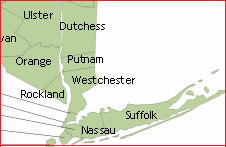

It could be automated by converting the pixels to coordinates, but with an approximation using Google Maps, latitude and longitude limits were found. 
* -74.76 < latitude < -71.93
* -74.76 < longitude < -71.93
Besides it, there might be some coordinates, as seen in the section 2.2, that have a zero value. 

In [ ]:
train.loc[(train.pickup_longitude == 0) | (train.pickup_latitude == 0) | (train.dropoff_longitude == 0) | (train.dropoff_latitude == 0)
          | (train.pickup_longitude < -74.76) | (train.pickup_longitude > -71.93) |
            (train.dropoff_longitude < -74.76) | (train.pickup_longitude > -71.93)|
            (train.pickup_latitude < 40.56) | (train.pickup_latitude > 42.07) |
            (train.dropoff_latitude < 40.56) | (train.dropoff_latitude > 42.07)].shape

In [ ]:
outside_boundaries = train.loc[(train.pickup_longitude == 0) | (train.pickup_latitude == 0) | (train.dropoff_longitude == 0) | (train.dropoff_latitude == 0)
          | (train.pickup_longitude < -74.76) | (train.pickup_longitude > -71.93) |
            (train.dropoff_longitude < -74.76) | (train.pickup_longitude > -71.93)|
            (train.pickup_latitude < 40.56) | (train.pickup_latitude > 42.07) |
            (train.dropoff_latitude < 40.56) | (train.dropoff_latitude > 42.07)].index
train.drop(outside_boundaries, inplace = True, errors='ignore')


## 4.6 Distance Outliers

From the section 3.2, we know that trips beyond 100km should be removed. The biggest distance that could happen should be from NYC to Dutchess county, that doesn't exceed 130Km. 

In [ ]:
train = train.loc[train.dist_km < 130]

# 5 Feature Engineering

Many factors could influence the fare amount related to a trip, and it might be overwhelming. However, searching in the NYC Government website, many rules can be found (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page). Based on them, and in other aspects related to the trip, some feature generation can be proposed.

1. Haversine Distance between locations
2. TimeStamps (Weekday, hour, month, year)
3. Congestion Surcharge 
4. Trips to/from Manhattan to/from JFK
5. Manhattan/JFK on rush hours
6. Westchester and Nassau counties
7. Distance from pickup/dropoff to key locations

## 5.1 Congestion Surcharge

As seen in the EDA, most part of the trips begin or and at Manhataan. According to the NYC Government website *"Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street".* With Google Maps help, we could define a latitude-longitude limitation for the south of the 96th street:

In [ ]:
Manhattan_south_96th = {
    'min_lat': 40.768394,
    'min_long':-73.993352,
    'max_lat': 40.795642,
    'max_long': -73.964942
}

Manhattan_south_96th['min_lat']

In [ ]:
temp = train.loc[((train.pickup_latitude > Manhattan_south_96th['min_lat']) & (train.pickup_latitude < Manhattan_south_96th['max_lat']) 
         & (train.pickup_longitude > Manhattan_south_96th['min_long']) & (train.pickup_longitude < Manhattan_south_96th['max_long']))
         | ((train.dropoff_latitude > Manhattan_south_96th['min_lat']) & (train.dropoff_latitude < Manhattan_south_96th['max_lat'])
         & (train.dropoff_longitude > Manhattan_south_96th['min_long']) & (train.dropoff_longitude < Manhattan_south_96th['max_long']))]
temp

In [ ]:

# import street map
street_map = gpd.read_file('../input/ny-map/geo_export_b5f6f452-87a0-46a0-95eb-2b80c4471a56.shp')
# designate coordinate system
crs = {'init':'espc:4326'}

sampled = temp.sample(frac=0.01)
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(sampled['pickup_longitude'], sampled['pickup_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(sampled,
 crs = crs,
 geometry = geometry)

sns.set_style("white")
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')

geo_df.plot(column='fare_amount',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('96th - South - Pickup/Dropoff', fontsize=15,fontweight='bold')

plt.xlim(-74.05,-73.925)
plt.ylim( 40.675,40.85)
# show map
plt.show()

There are some outliers, but our selection makes sense. Most locations are located at the south of the 96th street. Let's one hot encode these locations:

In [ ]:
train['south_manhattan'] = np.where(((train.pickup_latitude > Manhattan_south_96th['min_lat']) & (train.pickup_latitude < Manhattan_south_96th['max_lat']) 
         & (train.pickup_longitude > Manhattan_south_96th['min_long']) & (train.pickup_longitude < Manhattan_south_96th['max_long']))
         | ((train.dropoff_latitude > Manhattan_south_96th['min_lat']) & (train.dropoff_latitude < Manhattan_south_96th['max_lat'])
         & (train.dropoff_longitude > Manhattan_south_96th['min_long']) & (train.dropoff_longitude < Manhattan_south_96th['max_long'])), 1, 0)
test['south_manhattan'] = np.where(((test.pickup_latitude > Manhattan_south_96th['min_lat']) & (test.pickup_latitude < Manhattan_south_96th['max_lat']) 
         & (test.pickup_longitude > Manhattan_south_96th['min_long']) & (test.pickup_longitude < Manhattan_south_96th['max_long']))
         | ((test.dropoff_latitude > Manhattan_south_96th['min_lat']) & (test.dropoff_latitude < Manhattan_south_96th['max_lat'])
         & (test.dropoff_longitude > Manhattan_south_96th['min_long']) & (test.dropoff_longitude < Manhattan_south_96th['max_long'])), 1, 0)
del temp
del sampled
train

## 5.2 Trips to/from Airports

From the data exploration we've made, we know that airports have fixed fare and Manhattan concentrates most of the trips. Let's create some features based on that.

### 5.2.1 Trips Between Manhattan and JFK Airport

According to the government website *"Trips between Manhattan and John F. Kennedy Airport (JFK) in either direction: 52 dolars"*. So let's define these locations:

In [ ]:
Manhattan={
    "min_long":-74.02,
    "min_lat":40.70,
    "max_long":-73.93,
    "max_lat":40.85}

JFK={"min_long":-73.81,
    "min_lat":40.63,
    "max_long":-73.77,
    "max_lat":40.67}


How many trips begin in Manhattan and end in the JFK?

In [ ]:
train.loc[((train.pickup_latitude > Manhattan['min_lat']) & (train.pickup_latitude < Manhattan['max_lat']) & (train.pickup_longitude > Manhattan['min_long']) 
          & (train.pickup_longitude < Manhattan['max_long'])) & ((train.dropoff_latitude > JFK['min_lat']) & (train.dropoff_latitude < JFK['max_lat'])
          & (train.dropoff_longitude < JFK['max_long']) & (train.dropoff_longitude > JFK['min_long']))].shape

And how many begin in JFK and end in Manhattan?

In [ ]:
train.loc[((train.pickup_latitude > JFK['min_lat']) & (train.pickup_latitude < JFK['max_lat']) & (train.pickup_longitude > JFK['min_long']) 
          & (train.pickup_longitude < JFK['max_long'])) & ((train.dropoff_latitude > Manhattan['min_lat']) & (train.dropoff_latitude < Manhattan['max_lat'])
          & (train.dropoff_longitude < Manhattan['max_long']) & (train.dropoff_longitude > Manhattan['min_long']))].shape

Let's one hot encode these cases in a feature called Manhattan_JFK (from/to JFK from/to Manhattan)

In [ ]:
# JFK to Manh or Manh to JFK
train['Manhattan_JFK'] = np.where(((train.pickup_latitude > JFK['min_lat']) & (train.pickup_latitude < JFK['max_lat']) & (train.pickup_longitude > JFK['min_long']) 
          & (train.pickup_longitude < JFK['max_long'])) & ((train.dropoff_latitude > Manhattan['min_lat']) & (train.dropoff_latitude < Manhattan['max_lat'])
          & (train.dropoff_longitude < Manhattan['max_long']) & (train.dropoff_longitude > Manhattan['min_long'])) 
         | ((train.pickup_latitude > Manhattan['min_lat']) & (train.pickup_latitude < Manhattan['max_lat']) & (train.pickup_longitude > Manhattan['min_long']) 
          & (train.pickup_longitude < Manhattan['max_long'])) & ((train.dropoff_latitude > JFK['min_lat']) & (train.dropoff_latitude < JFK['max_lat'])
          & (train.dropoff_longitude < JFK['max_long']) & (train.dropoff_longitude > JFK['min_long'])), 1,0)


test['Manhattan_JFK'] = np.where(((test.pickup_latitude > JFK['min_lat']) & (test.pickup_latitude < JFK['max_lat']) & (test.pickup_longitude > JFK['min_long']) 
          & (test.pickup_longitude < JFK['max_long'])) & ((test.dropoff_latitude > Manhattan['min_lat']) & (test.dropoff_latitude < Manhattan['max_lat'])
          & (test.dropoff_longitude < Manhattan['max_long']) & (test.dropoff_longitude > Manhattan['min_long'])) 
         | ((test.pickup_latitude > Manhattan['min_lat']) & (test.pickup_latitude < Manhattan['max_lat']) & (test.pickup_longitude > Manhattan['min_long']) 
          & (test.pickup_longitude < Manhattan['max_long'])) & ((test.dropoff_latitude > JFK['min_lat']) & (test.dropoff_latitude < JFK['max_lat'])
          & (test.dropoff_longitude < JFK['max_long']) & (test.dropoff_longitude > JFK['min_long'])), 1,0)

train

#### 5.2.1.1 Manhattan/JFK Rush Hour Surcharge

From the Rush Hour data exploration, we know that 4-8pm has the highest demand of the dataset. NYC Gov determines: "*4.50 dolar rush hour surcharge (4pm to 8pm weekdays, excluding legal holidays)"* Associating that with Manhattan pickup/dropoff importance, and fixed fare trips from JFK airport, let's see how many match this condition.

In [ ]:
train.loc[(train.Manhattan_JFK == 1) & ((train.hour >=16) & (train.hour <=20) & (train.weekday >= 0) & (train.weekday <=4))].shape

One hot encoding the trips that match this condition:

In [ ]:
train['Manhattan_JFK_rush'] = np.where((train.Manhattan_JFK == 1) & ((train.hour >=16) & (train.hour <=20) & (train.weekday >= 0) & (train.weekday <=4)),1,0)
test['Manhattan_JFK_rush'] = np.where((test.Manhattan_JFK == 1) & ((test.hour >=16) & (test.hour <=20) & (test.weekday >= 0) & (test.weekday <=4)),1,0)
train

### 5.2.2 Trips to/from LGA

From EDA and from NYC Gov: "*Trips to and from LaGuardia Airport (LGA) are charged the standard metered fare*". Let's define the coordinates of LGA airport:

In [ ]:
LGA = {
    "min_long":-73.89,
    "min_lat":40.76,
    "max_long":-73.85,
    "max_lat":40.79
}

How many trips begin or end at La Guardia Airport?

In [ ]:
train.loc[((train.pickup_latitude > LGA['min_lat']) & (train.pickup_latitude < LGA['max_lat']) & (train.pickup_longitude > LGA['min_long'])
          & (train.pickup_longitude < LGA['max_long'])) | ((train.dropoff_latitude > LGA['min_lat']) & (train.dropoff_latitude < LGA['max_lat']) & (train.dropoff_longitude > LGA['min_long'])
          & (train.dropoff_longitude < LGA['max_long']))].shape

One hot encoding these locations:

In [ ]:
train['LGA_pick_drop'] = np.where(((train.pickup_latitude > LGA['min_lat']) & (train.pickup_latitude < LGA['max_lat']) & (train.pickup_longitude > LGA['min_long'])
          & (train.pickup_longitude < LGA['max_long'])) | ((train.dropoff_latitude > LGA['min_lat']) & (train.dropoff_latitude < LGA['max_lat']) & (train.dropoff_longitude > LGA['min_long'])
          & (train.dropoff_longitude < LGA['max_long'])),1,0)
test['LGA_pick_drop'] = np.where(((test.pickup_latitude > LGA['min_lat']) & (test.pickup_latitude < LGA['max_lat']) & (test.pickup_longitude > LGA['min_long'])
          & (test.pickup_longitude < LGA['max_long'])) | ((test.dropoff_latitude > LGA['min_lat']) & (test.dropoff_latitude < LGA['max_lat']) & (test.dropoff_longitude > LGA['min_long'])
          & (test.dropoff_longitude < LGA['max_long'])),1,0)
train.head()

## 5.3 Overnight Trips 

From section 3.1.2, we infered that overnight trips have the highest mean fare amount. NYC Gov says"*Plus 50 cents overnight surcharge 8pm to 6am*"

In [ ]:
train.loc[(train.hour >= 20) | (train.hour <=6)].shape

So there is more than a million trips in this condition.

In [ ]:
train['overnight'] = np.where(((train.hour >= 20) | (train.hour <=6)),1,0)
test['overnight'] = np.where(((test.hour >= 20) | (test.hour <=6)),1,0)
train.head()

## 5.4 Rush Hour

From section 3.1.1, we know that 4-8pm is a rush hour. Besides it, NYC gov says: "*Plus 1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays*"

In [ ]:
train.loc[((train.hour >= 16) & (train.hour <= 20)) & ((train.weekday >= 0 ) & (train.weekday <=4))].shape

In [ ]:
train['rush_hour'] =  np.where(((train.hour >= 16) & (train.hour <= 20)) & ((train.weekday >= 0 ) & (train.weekday <=4)),1,0)
test['rush_hour'] =  np.where(((test.hour >= 16) & (test.hour <= 20)) & ((test.weekday >= 0 ) & (test.weekday <=4)),1,0)
train

## 5.5 Distance to Key Locations

If we can determine the distance between pickup and dropoff points of the city, it would be an useful feature for the model. With that, the actual pickup location could be estimated, and so could the dropoff. Hence, the model could set boundaries on the map and triangulate the locations, making better predictions. 

### 5.5.1 Places Within NYC

Setting the approximate coordinates to these city locations:

In [ ]:
city_center = {"long":-74.0060,"lat":40.7128}
JFK = {"long":-73.7781,"lat": 40.6413}
EWR = {"long":-74.1745,"lat": 40.6895}
LGR = {"long":-73.8740,"lat": 40.7769}
locations_within_city = [city_center,JFK,EWR,LGR]

Calling the haversine method and adding these values to the dataset:

In [ ]:
def haversineMod(lon1,lat1,lon2,lat2):
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1,lat1,lon2,lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6367 * c
    return distance

pickup_array = ['pickup_to_city_center','pickup_to_jfk','pickup_to_ewr','pickup_to_lgr']
dropoff_array = ['dropoff_to_city_center','dropoff_to_jfk','dropoff_to_ewr','dropoff_to_lgr']
pickup_array

for feature in range(len(pickup_array)):
    train[pickup_array[feature]] = haversineMod(train['pickup_longitude'].to_numpy(), train['pickup_latitude'].to_numpy(), locations_within_city[feature]['long'], locations_within_city[feature]['lat'])
    train[dropoff_array[feature]] = haversineMod(train['dropoff_longitude'].to_numpy(), train['dropoff_latitude'].to_numpy(), locations_within_city[feature]['long'], locations_within_city[feature]['lat'])
    test[pickup_array[feature]] = haversineMod(test['pickup_longitude'].to_numpy(), test['pickup_latitude'].to_numpy(), locations_within_city[feature]['long'], locations_within_city[feature]['lat'])
    test[dropoff_array[feature]] = haversineMod(test['dropoff_longitude'].to_numpy(), test['dropoff_latitude'].to_numpy(), locations_within_city[feature]['long'], locations_within_city[feature]['lat'])

train.shape

### 5.5.2 Places Outside NYC - Counties

EDA shows us some dropoff and pickup locations outside the city. From the government website we know "*Out of City Rate to Nassau or Westchester." The metered fare is double the amount from the City limit to your destination*". To other points outside the city, "*The 50 cents MTA State Surcharge must be added to the flat rate for any trip that ends in the following counties: Dutchess, Orange, Putnam, Rockland or Suffolk.*". Therefore, it is important to calculate the pickup and dropoff locations to these counties. Estimating these locations with Google Maps gives:

In [ ]:
Dutchess = {"long":-73.7478,"lat":41.7784} #
Orange = {"long":-74.3118,"lat":41.3912} #ok
Putnam = {"long":-73.7949,"lat": 41.4351} #ok
Rockland = {"long":-73.9830,"lat": 41.1489} #ok
Suffolk = {"long":-72.6151,"lat": 40.9849} #ok 
Nassau = {"long":-73.5594,"lat": 40.6546}  #ok
Westchester = {"long":-73.7949,"lat": 41.1220} #ok

locations_outside = [Dutchess,Orange,Putnam,Rockland,Suffolk,Nassau,Westchester]
pickup_array = ['pickup_to_city_dutchess','pickup_to_orange','pickup_to_putnam','pickup_to_rockland','pickup_to_suffolk','pickup_to_nassau','pickup_to_westchester']
dropoff_array = ['dropoff_to_city_dutchess','dropoff_to_orange','dropoff_to_putnam','dropoff_to_rockland','dropoff_to_suffolk','dropoff_to_nassau','dropoff_to_westchester']

In [ ]:
for feature in range(len(pickup_array)):
    train[pickup_array[feature]] = haversineMod(train['pickup_longitude'].to_numpy(), train['pickup_latitude'].to_numpy(), locations_outside[feature]['long'], locations_outside[feature]['lat'])
    train[dropoff_array[feature]] = haversineMod(train['dropoff_longitude'].to_numpy(), train['dropoff_latitude'].to_numpy(), locations_outside[feature]['long'], locations_outside[feature]['lat'])
    test[pickup_array[feature]] = haversineMod(test['pickup_longitude'].to_numpy(), test['pickup_latitude'].to_numpy(), locations_outside[feature]['long'], locations_outside[feature]['lat'])
    test[dropoff_array[feature]] = haversineMod(test['dropoff_longitude'].to_numpy(), test['dropoff_latitude'].to_numpy(), locations_outside[feature]['long'], locations_outside[feature]['lat'])

In [ ]:
train.shape

# 6. Correlation After Feature Engineering

In [ ]:
#train['fare_amount'] = y
indexes = abs(train.corrwith(train['fare_amount'])).index.to_list()
features = np.array(abs(train.corrwith(train['fare_amount'])))
data = {'Feature':indexes,'corr_to_target':features}
df = pd.DataFrame(data)
df = df.sort_values(by='corr_to_target',ascending = False).reset_index()
df.head()

In [ ]:
plt.figure(figsize=(14,14))
sns.set_style('whitegrid')
ax = sns.barplot(x='corr_to_target', y='Feature', data=df)
ax.set_xlabel('Correlation to Target', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Absolute Feature Correlation Value With Target Variable')

As illustrated above, after the data cleaning, almost all variables had its correlation values increased. We have now 13 variables with a correlation higher than 0.3. 

In [ ]:
# 7. Models Training 

## 7.1 Data Split

In [ ]:
y = train['fare_amount']
train.drop(columns = ['fare_amount'], axis = 1,inplace=True, errors = 'ignore')

X_train, X_validation, y_train, y_valid = train_test_split(train, y,train_size=0.8, test_size=0.2,random_state=0)

In [ ]:
import time
model_name = []
elapsed_time = []

## 7.2 XGB Regressor

The ideal was to show the impact of changing the number of estimators and the learning rate. However, due to the dataset size, it would take a long time to commit. From previous tests, it was found that n_estimators higher than a hundred wouldn't contribute to a lower RMSE. A learning_rate of 0.08 proved to cause the lowest RMSE values. 

In [ ]:
def runXGB(X_train_clean,y_train_clean,X_validation_clean,y_validation_clean,n_est,learning_r,jobs):
   

    model = XGBRegressor(n_estimators=n_est, learning_rate=learning_r, n_jobs=jobs)
    model.fit(X_train_clean, y_train_clean,
                  early_stopping_rounds=20,
                  eval_set=[(X_validation_clean, y_validation_clean)],
                  verbose = False) 

    predictions_2 = model.predict(X_validation_clean)
    mae_2 = mean_absolute_error(predictions_2, y_validation_clean) 

    return mae_2,model

In [ ]:
mae_approach_1 = []
model_approach_1 = []

start_time = time.time()
mae_2, model = runXGB(X_train,y_train,X_validation,y_valid,100,0.1,2)


pred = model.predict(X_validation)
mse = mean_squared_error(y_valid, pred)
rmse = math.sqrt(mse)
print(rmse)
end_time = time.time() - start_time 
model_name.append('XBG')
elapsed_time.append(end_time)

## 7.3 LGBM

Empirically, these were the parameter that proved to be the better ones in RSME aspect. Learning rate around 0.06 produces a relatively slow run, but it reaches what it seems to be a global mininum. The early stopping rounds was chosen to be 400 because it takes a very long time to run the model with a higher number of examples. 'gbdt' proved to be the best boosting type for this problem compared to dart. 

In [ ]:
import lightgbm as lgbm
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.06,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':500
    }


def LGBMmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = lgbm.Dataset(X_train, y_train)
    matrix_test = lgbm.Dataset(X_test, y_test)
    model=lgbm.train(params=params,
                    train_set=matrix_train,
                    num_boost_round=2, 
                    early_stopping_rounds=400,
                    verbose_eval=100,
                    valid_sets=matrix_test)
    return model
start_time = time.time()
model = LGBMmodel(X_train,X_validation,y_train,y_valid,params)

In [ ]:
pred = model.predict(X_validation)
mse_2 = mean_squared_error(y_valid, pred)
rmse_2 = math.sqrt(mse_2)
print(rmse_2)
end_time = time.time() - start_time 
model_name.append('LGBM')
elapsed_time.append(end_time)

In [ ]:
d = dict(zip(model_name,elapsed_time))
d

# 7.4 Predicting Test Set

In [ ]:
y_pred = model.predict(test)
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission['fare_amount'] = y_pred
submission.to_csv('submission_XGB.csv', index=False)
submission.head(5)

# 8. Conclusion

In [ ]:
data = {'Model':list(d.keys()),'Time Elapsed': [list(d.values())[1],list(d.values())[0]], 'RMSE':[rmse,rmse_2]}
pd.DataFrame(data)

* As demonstrated trough the EDA and further feature correlation analysis, we have reached an impressive correlation of the generated features. This is due to a good data cleaning and confirmation of hypothesis. However, we could have removed more outliers, such as the indicated in the section 3.4 and the location points marked in water areas (dist_km went from 0.025 to 0.8 correlation).
* The models, on the training set, have reached a relatively good RMSE. For further approaches, some analysis taking into consideration a variation on the feature selection, such as selecting higher correlated features, are recommended. It won't help much, but could save time from the model for taking not relevant decisions. 
* We have chosen two robust and famous models due to their good performance with previous tabular data. The difference between them is not enormous, but it is significant to our problem. Let's enlight some reasons why LGBM had a better performance over XGBOOST:

#### 1. As seen experimentaly, LGBM is faster. This can be related to its histogram based algorithm that bins continous features into discrete values, making the training process faster. It is essential, especially for large datasets as ours. 
#### 2. It performs better in terms of RMSE by using what is called as leaf wise split approach. It provides much more complex trees that helps the model making better decisions. 
#### 3. Doing some researches, it can be seen that LGBM is an improvment of XGBoost. The accuracies are comparable, but the time taken is completely different. Besides it, as mentioned, LGBM reaches lower RMSE due to their complex trees. 
#### 4. LGBM uses a gradient based technique (GOSS) to filter data instances finding for a split value, while XGBoost uses a pre-selected algorithm and histogram based algorithm to calculate a better division. In practice, the histogram based algorithm divides all data points in discrete bins, using them to select the histogram split value. Comparing the last one to GOSS results in lower speed for a similar RMSE value.

* For further improvements, we suggest removing more outliers and a better fine-tuning, such as bayesian methods. 


# References 
[1] https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration 
[2] https://medium.com/analytics-vidhya/exploratory-data-analysis-of-nyc-taxi-trip-duration-dataset-using-python-257fdef2749e
[3] https://towardsdatascience.com/exploratory-data-analysis-eda-a-practical-guide-and-template-for-structured-data-abfbf3ee3bd9
[4] https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184
[5] https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model
[6] https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters